# Examen Parcial

## Código Anterior

In [2]:
import csv
import numpy as np
import pandas as pd

from random import random
from IPython.display import display, Math
import math

import matplotlib.pyplot as plt

In [2]:
def gradiente(f, xk, eps = 1e-6):
    size = len(xk)
    grad = np.zeros(size)
    for i in range(size):
        x_f = xk.copy(); x_f[i] += eps
        x_b = xk.copy(); x_b[i] -= eps
        grad[i] = (f(x_f) - f(x_b)) / (2 * eps)
    return grad

In [3]:
def hessiana(f,xk, eps = 1e-3):
    size = len(xk)
    hess = np.zeros((size, size))
    for j in range(size):
        # Primera derivada
        dx_ff = xk.copy(); dx_ff[j] += eps;
        dx_bb = xk.copy(); dx_ff[j] += eps;
        grad_f = gradiente(f, dx_ff)
        grad_b = gradiente(f, dx_bb)
        for i in range(j+1):
            # Segunda derivada
            hess[i, j] = (grad_f[i] - grad_b[i]) / (2 * eps)
            hess[j, i] = (grad_f[i] - grad_b[i]) / (2 * eps)
    return hess

In [4]:
def BLS(f, xk, alpha_0, pk, c):
    alpha = alpha_0
    while f(xk + alpha * pk) > f(xk) + c * alpha * gradiente(f, xk) @ pk:
        p = random()
        alpha = p * alpha
    return alpha

In [5]:
def CAMI(A):
    beta = 0.001
    n = len(A)
    if min(np.diag(A)) > 0:
        t = 0
    else:
        t = -min(np.diag(A)) + beta
    for k in range(100):
        try:
            np.linalg.cholesky(A + t * np.identity(n))
        except np.linalg.LinAlgError as err:
            t = max(2 * t, beta)
        else:
            break
    return A + t * np.identity(n)

In [6]:
def LSNM(f, xk):
    for k in range(100):
        Bk = hessiana(f, xk)
        # Calculamos si es semipositiva definida
        try:
            np.linalg.cholesky(Bk)
        except np.linalg.LinAlgError as err:
            # Si no lo es, la convertimos en matriz semipositiva
            Bk = CAMI(Bk)   
        # Aplicamos el método de Newton
        pk = np.linalg.solve(Bk, - gradiente(f, xk))
        xk = xk + BLS(f, xk, 1, pk, 0.5) * pk
    return xk

## Ejercicio 3

### Idea 1
Una primera solución sería minimizar la distancia que hay entre cada coordenada de crimen y la camara más cercana, sin embargo, calcular esta función sería muy tardado para 8000 cámaras y no es una función suave, por lo que nuestros algoritmos usuales podrían no funcionar.
Una manera de realizar esto sería transformando el problema a uno de optimización de una variable t, de tal forma que se cumpliera que la distancia mínima entre cada camara y crimen fuera menor a t, pero sería minimización con restricciones.

In [3]:
# Nos quedamos con la latitud y longitud de cada dato
data=pd.read_csv('crime_data.csv')
data = data[{'lat','long'}]

crimes = data.to_numpy()

In [4]:
def dist_point(p1, p2):
    return math.sqrt(((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2))
def dist(x, p1):
    size = len(x)
    y = np.zeros(size)
    for i in range(size):
        y[i] = dist_point(x[i], p1)
    return y
def min_distance(x, c = crimes):
    suma = 0
    for i in range(len(c)):
        suma += np.min(dist(x,c[i]))
    return suma

In [ ]:
x = np.zeros(shape=(8000, 2)) # Generamos la posición de las camaras iniciales

# La función min_distance recibe la posición de las 8000 camaras y todas las escenas de crimenes, y devuelve la suma de 
# la distancia entre cada escena del crimen y la camara más cercana.

LSNM(min_distance, x)

### Idea 2
Una segunda idea sería agrupar a todos los crimenes en a lo más 8000 grupos, para así asignarle a cada grupo una o más camaras dependiendo de la densidad del grupo, en dónde se buscaría optimizar el número de grupos.
Una manera de asignar a los integrantes de cada grupo sería a través de k-means clustering, pero hay otras.

##### Mapa de los crímenes

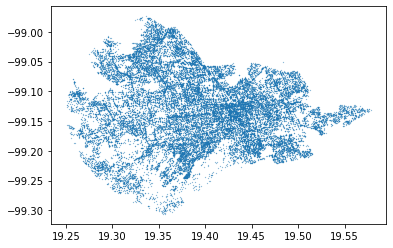

In [5]:
lat = data['lat']
long = data['long']
plt.plot(lat,long,'o', markersize = 0.2)

In [ ]:
from sklearn.cluster import KMeans

n = 8000 # numero de clusters
kmeans = KMeans(n_clusters = n, init ='k-means++')
kmeans.fit(data)
data['grupo'] = kmeans.fit_predict(data)
data.groupby('grupo').count()